In [16]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# K Means Clustering
This section will use K Means Clustering on the cleaned data

In [17]:
# Importing the data
file_path = "cleaned_data/final_data.csv"  
original_data = pd.read_csv(file_path)

df = original_data.copy()
# drop because will skew results
df = df.drop("ID", axis = 1)
df = df.drop("label", axis = 1)

display(df)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,DAYS_EMPLOYED_CLEAN
0,M,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2,59,3.0
1,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,52,8.5
2,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,52,8.5
3,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,52,8.5
4,F,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,52,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25121,F,1,1,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3,30,5.0
25122,F,1,1,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3,30,5.0
25123,F,1,1,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3,30,5.0
25124,F,1,1,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10808,-1739,1,0,0,0,Core staff,3,30,5.0


### Encoding -
Some variables must be encoded in order to be used in K Means Clustering. Examining the data below, there is one ordinal variable (NAME_EDUCATION_TYPE). This will be encoded using manual label encoding. The rest of the variables will be encoded using one-hot encoding.

In [18]:
cols_to_encode = [col for col in df.columns if df[col].dtype not in ["int64", "float"]]
df[cols_to_encode].nunique()
for col in cols_to_encode:
    print(f"Unique values in {col}: {df[col].unique()}")

Unique values in CODE_GENDER: ['M' 'F']
Unique values in NAME_INCOME_TYPE: ['Working' 'Commercial associate' 'State servant' 'Student' 'Pensioner']
Unique values in NAME_EDUCATION_TYPE: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
Unique values in NAME_FAMILY_STATUS: ['Married' 'Single / not married' 'Civil marriage' 'Separated' 'Widow']
Unique values in NAME_HOUSING_TYPE: ['House / apartment' 'Rented apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']
Unique values in OCCUPATION_TYPE: ['Security staff' 'Sales staff' 'Accountants' 'Laborers' 'Managers'
 'Drivers' 'Core staff' 'High skill tech staff' 'Cleaning staff'
 'Cooking staff' 'Low-skill Laborers' 'Medicine staff'
 'Private service staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'Realty agents' 'IT staff']


In [19]:
education_mapping = custom_order = [['Lower secondary', 'Secondary / secondary special', 
                 'Incomplete higher', 'Higher education', 'Academic degree']]
ordinal_encoder = preprocessing.OrdinalEncoder(categories = education_mapping)
df["NAME_EDUCATION_TYPE"] = ordinal_encoder.fit_transform(df[["NAME_EDUCATION_TYPE"]])

In [20]:
# cols_to_encode.remove("NAME_EDUCATION_TYPE")
one_hot_encoder = preprocessing.OneHotEncoder(sparse_output = False)
encoded_data = one_hot_encoder.fit_transform(df[cols_to_encode])

# Create new cols
encoded_names = one_hot_encoder.get_feature_names_out(cols_to_encode)

# Convert to dataframe
encoded_df = pd.DataFrame(encoded_data, columns = encoded_names)
df = pd.concat([df, encoded_df], axis = 1)
df.drop(cols_to_encode, axis = 1, inplace = True)
df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,1,1,0,112500.0,-21474,-1134,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,1,0,270000.0,-19110,-3051,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,1,0,270000.0,-19110,-3051,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,1,0,270000.0,-19110,-3051,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1,0,270000.0,-19110,-3051,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Standardizing - 
The data has already been cleaned but we will standardize the data in order to make sure distance calculations aren't being overly skewed by one variable

In [21]:
df.describe()

# Creating instance of scaler
standard_scaler = preprocessing.StandardScaler()

cols_to_scale = [col for col in df.columns]

# Standardizing data frame
df[cols_to_scale] = standard_scaler.fit_transform(df[cols_to_scale])
df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,1.178787,0.725723,-0.650508,-0.788017,-1.916039,0.637613,0.0,-0.614121,-0.643518,-0.334320,...,-0.57303,-0.083748,-0.369057,-0.224637,-0.117644,-0.056161,-0.400893,-0.077756,6.437590,-0.083507
1,-0.848330,0.725723,-0.650508,0.718951,-1.237735,-0.181867,0.0,-0.614121,1.553958,2.991146,...,-0.57303,-0.083748,-0.369057,-0.224637,-0.117644,-0.056161,2.494432,-0.077756,-0.155338,-0.083507
2,-0.848330,0.725723,-0.650508,0.718951,-1.237735,-0.181867,0.0,-0.614121,1.553958,2.991146,...,-0.57303,-0.083748,-0.369057,-0.224637,-0.117644,-0.056161,2.494432,-0.077756,-0.155338,-0.083507
3,-0.848330,0.725723,-0.650508,0.718951,-1.237735,-0.181867,0.0,-0.614121,1.553958,2.991146,...,-0.57303,-0.083748,-0.369057,-0.224637,-0.117644,-0.056161,2.494432,-0.077756,-0.155338,-0.083507
4,-0.848330,0.725723,-0.650508,0.718951,-1.237735,-0.181867,0.0,-0.614121,1.553958,2.991146,...,-0.57303,-0.083748,-0.369057,-0.224637,-0.117644,-0.056161,2.494432,-0.077756,-0.155338,-0.083507


### Checking Dimensional Reduction Using PCA - 
Aiming to reduce the dimensions in the data. We first use a cumulative variance plot to see how many variables we want to keep.

Text(0, 0.5, 'Cumulative Explained Variance')

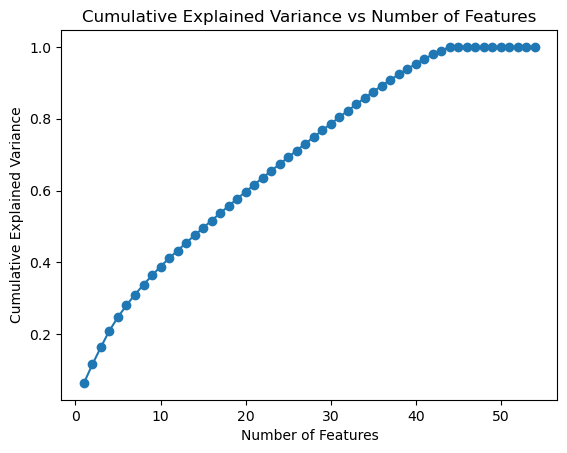

In [22]:
pca = PCA()
pca.fit(df)
pca.explained_variance_ratio_
plt.plot(range(1, 55), pca.explained_variance_ratio_.cumsum(), "o-")
plt.title("Cumulative Explained Variance vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Explained Variance")

Because PCA doesn't seem to reduce the features in a tremendous way and it will decrease the interpretability greatly, we will not use it in this algorithm.

### Checking for the optimum number of clusters
We will use the elbow method to see what the critical point is. Inertia is used to judge how closely grouped data points are in a cluster. Because we standardized the data before hand, inertia provides a good metric. The formula for inertia is $ \sum_{i=1}^{k} \sum_{x \in C_i} || x - \mu_i ||^2 $. 

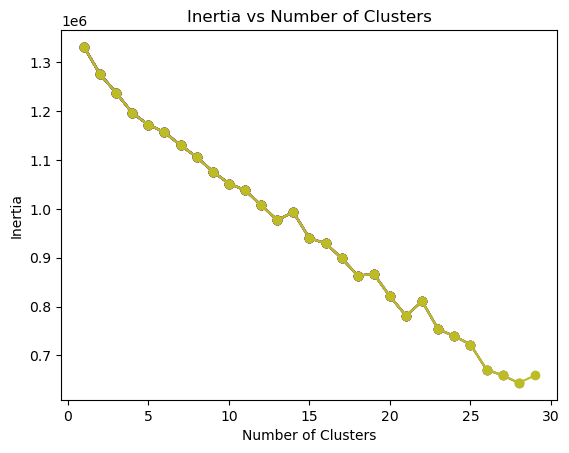

In [23]:
def optimise_cluster_count(data, max_k):
    count = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(df)
        count.append(k)
        inertias.append(kmeans.inertia_)

        plot = plt.plot(count, inertias, "o-")
        plt.title("Inertia vs Number of Clusters")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Inertia")
        plt.grid = True
        plt.show

optimise_cluster_count(df, 30)

### Applying K Means Clustering
Based on the graph above, it seems as though around 5 clusters the inertia starts to decrease more slowly. As such, we will use k = 5. 

In [24]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit(df)
df["K Means Cluster"] = kmeans.labels_

### Key Takeaways - 

In [25]:
score = silhouette_score(df, kmeans.labels_)
score

0.05647447641826479

# Attempting K Means Clustering Again Pt 2.
Taking into account the previous information gained, we will try and use feature selection to reduce the amount of variables and have clearer visualizations. Based on a basic understanding of credit approvals, the following features should be significant - 

<ol>
  <li>Annual income - Signifies repayment abilities</li>
  <li>Occupation - Ties in to job stability</li>
  <li>Days employed - Ties in to job stability</li>
  <li>Family Size - Financial obligations</li>
</ol>

The following features were removed for these reasons:

<ol>
  <li>Income category - Doesn't add very meaningful information compared to income </li>
  <li>Education level - Similar to income potential </li>
  <li>Label - Created variable that isn't needed for unsupervised </li>
  <li>Children count - Similar to family size</li>
    <li> Days employed clean - Similar to days employed</li>
</ol>

Non relevance - Gender, Own car, own realty, housing type, days birth, mobil phone, flag work phone, age, family status

In [26]:
feature_selected_df = df[["AMT_INCOME_TOTAL", "DAYS_EMPLOYED", "CNT_FAM_MEMBERS"]]
feature_selected_df.head()

unique_values = {col: feature_selected_df[col].unique() for col in feature_selected_df.columns}
for col, values in unique_values.items():
    print(f"{col} ({len(values)} unique values): {values[:10]}") 

AMT_INCOME_TOTAL (195 unique values): [-0.78801688  0.71895141 -0.57273569 -0.61579193 -0.35745451  2.0106385
  0.15922033  1.58007614 -0.65884817  0.50367022]
DAYS_EMPLOYED (3298 unique values): [ 0.63761336 -0.18186688  0.79364377  0.61196453  0.65086526  0.49440737
  0.62521642  0.2605755  -0.77991219 -0.23401951]
CNT_FAM_MEMBERS (10 unique values): [-0.31075913 -1.36619761  2.85555631  0.74467935  1.80011783  3.9109948
 13.40994113  4.96643328 18.68713353  7.07731024]


### Checking for optimum amount of clusters - Using Gap statistics
The data has already been standardized in previous steps and the variables have been selected so we can move on to determining the optimum amount of clusters. Instead of using the elbow method, we will be using the Gap statistic as it is less subjective

In [27]:
def compute_gap_statistic(df, k_max, n_replicates = 10):
    # To see if clusters are just randomness or meaningful
    def generate_reference_data(X):
        return np.random.uniform(low=df.min(axis=0), high=df.max(axis=0), size=df.shape)

    gap_values = []

    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(df)
        data_inertia = kmeans.inertia_

        replicates_inertia = []
        for _ in range(n_replicates):
            random_data = generate_reference_data(df)
            kmeans.fit(random_data)
            replicates_inertia.append(kmeans.inertia_)


        gap = np.log(np.mean(replicates_inertia)) - np.log(data_inertia)
        gap_values.append(gap)

    return gap_values

Text(0, 0.5, 'Gap Statistic')

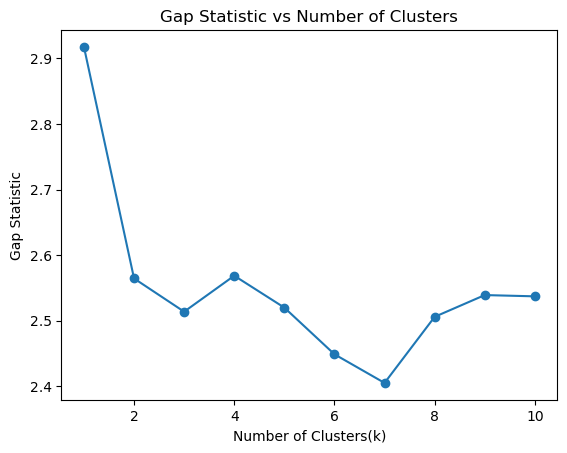

In [28]:
k_max = 10
gap_values = compute_gap_statistic(feature_selected_df, k_max)


plt.plot(range(1, k_max + 1), gap_values, "o-")
plt.title("Gap Statistic vs Number of Clusters")
plt.xlabel("Number of Clusters(k)")
plt.ylabel("Gap Statistic")

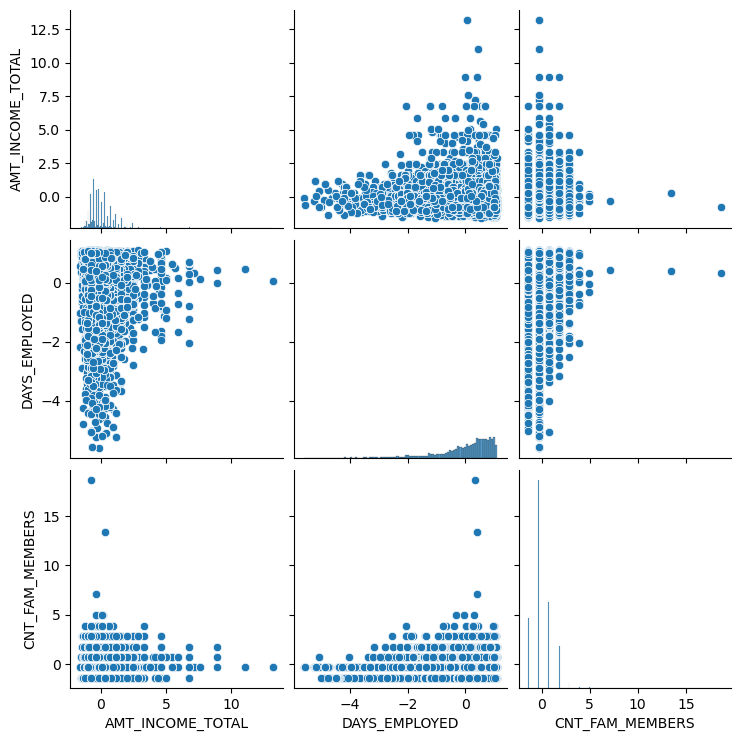

In [29]:
import seaborn as sns
sns.pairplot(feature_selected_df)
plt.show()

# Conclusions
In this section, we took the cleaned data, encoded it, and standardized it. We then attempted PCA but when we found it didn't drastically reduce dimensionality, we decided to forgo it for K Means for interpretability. 

A inertia elbow graph was used to find the best k value and the K Means Clustering algorithm was ran with this value of k. The silhouette score found was near 0, indicating overlapping clusters.

Another method was done where the features were selected using domain knowledge and the gap statistic was used to evaluate clusters. This also found no clear clusters within the data. Further examinations of the data confirm this.

# References
One Hot Encoding - https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

Clustering - https://towardsdatascience.com/how-to-use-unsupervised-learning-to-cluster-well-log-data-using-python-a552713748b5/

PCA - https://365datascience.com/tutorials/python-tutorials/pca-k-means/

Gap Statistic - https://www.geeksforgeeks.org/gap-statistics-for-optimal-number-of-cluster/